In [1]:
%load_ext autoreload
%autoreload 2
import os
import glob
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
pd.options.display.max_columns = 999
#pd.options.display.max_rows = 100
import seaborn as sns 
import indicoio
import sys
sys.path.append("../../Code")
import utils
sys.path.append("../../Tools/python-client")
from __future__ import print_function
import time
from pprint import pprint
import settings as s
import images as im
import cognitive as cog
import files as f
import demographics as demo

/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Load Data 

## Review

### Restricted by number of Reviews per host

In [2]:
nr_hosts = pd.read_csv('../2/nr_restrict_hosts.csv', index_col=0)
nr_hosts = nr_hosts[~nr_hosts.index.isnull()]
nr_listings = pd.read_csv('../2/nr_restrict_listings.csv', index_col=0)
nr_guests = pd.read_csv('../2/nr_restrict_guests.csv', low_memory=False, index_col=0)
nr_reviews = pd.read_csv('../2/nr_restrict_reviews.csv', index_col=0)

In [3]:
len(nr_reviews.drop_duplicates())

215960

In [4]:
len(nr_hosts.drop_duplicates())

6924

In [5]:
len(nr_guests.drop_duplicates())

96255

### Reduce reviews to those where we have both hosts and guests 

In [6]:
reviews, h_ids, g_ids = utils.reduce_reviews(nr_reviews, nr_hosts, nr_guests)

Total Reviews: 105600 
Unique Hosts: 5591 
Unique Guests: 96255


# Indico

## Hosts

In [7]:
hosts_indicio = pd.read_csv('hosts_with_people.csv', index_col=0)

In [8]:
im.print_pip_proportions(hosts_indicio, 'num_of_people_in_pic')

+-------+-----------+--------------+--------------+--------------+------------+-----------+-----------+
| total |    n/a    |      0       |      1       |      2       |     3      |     4     |    >=5    |
+-------+-----------+--------------+--------------+--------------+------------+-----------+-----------+
| 12319 | 15(0.12%) | 4022(32.65%) | 6473(52.54%) | 1484(12.05%) | 250(2.03%) | 59(0.48%) | 16(0.13%) |
+-------+-----------+--------------+--------------+--------------+------------+-----------+-----------+


In [9]:
hosts_one = hosts_indicio[hosts_indicio.num_of_people_in_pic == 1]

In [10]:
len(hosts_one)

6473

## Guests

In [11]:
guests_indicio = pd.read_csv('final_guest_indicoio.csv', index_col=0)

In [12]:
im.print_pip_proportions(guests_indicio, 'num_of_people')

+--------+-------------+---------------+---------------+---------------+-------------+------------+------------+
| total  |     n/a     |       0       |       1       |       2       |      3      |     4      |    >=5     |
+--------+-------------+---------------+---------------+---------------+-------------+------------+------------+
| 102161 | 9898(9.69%) | 22920(22.44%) | 51667(50.57%) | 14175(13.88%) | 2638(2.58%) | 593(0.58%) | 270(0.26%) |
+--------+-------------+---------------+---------------+---------------+-------------+------------+------------+


Guests have almost 10 % less empty picture profile pics than host - Hosts emphasis that the main attraction is the house 

EXTRA - tie host trips together with host pic . How many that are travellers have a pic . 

In [13]:
guests_one = guests_indicio[guests_indicio.num_of_people == 1]

In [14]:
len(guests_one)

51667

### Reduce reviews to those where both host and guests are only 1 person in the picture

In [15]:
reviews_one_on_one, h_one_ids, g_one_ids = utils.reduce_reviews(reviews, hosts_one, guests_one)

Total Reviews: 31350 
Unique Hosts: 2843 
Unique Guests: 29499


# Cognitive Tool

### Read in all Indicio output 

In [16]:
hosts_cog = pd.read_csv('final_cog_hosts.csv', index_col=0).drop("Unnamed: 1", axis=1)
guests_cog = pd.read_csv('final_cog_guests.csv', index_col=0).drop_duplicates()

In [17]:
hosts_cog = im.clean_cognitive_table(hosts_cog).rename(columns={'name':'id'})
guests_cog = im.clean_cognitive_table(guests_cog).rename(columns={'name':'id'})

In [18]:
len(hosts_cog)

3522

In [19]:
len(guests_cog)

50177

In [20]:
hosts_cog.noiseLevel.value_counts(dropna=False)

low       2179
NaN        631
medium     491
high       221
Name: noiseLevel, dtype: int64

In [21]:
guests_cog.noiseLevel.value_counts(dropna=False)

low       30493
NaN        9281
medium     7181
high       3222
Name: noiseLevel, dtype: int64

In [22]:
hosts_low = hosts_cog[hosts_cog['noiseLevel'] == 'low']
guests_low = guests_cog[guests_cog['noiseLevel'] == 'low']

In [23]:
reviews_cog, h_cog_ids, g_cog_ids = utils.reduce_reviews(nr_reviews, hosts_low, guests_low)



Total Reviews: 19978 
Unique Hosts: 2100 
Unique Guests: 19334


In [24]:
results = reviews_cog[['id', 'reviewer_id', 'recipient_id']]

In [25]:
results = results.join(hosts_low[['id', 'age', 'gender','smile']].rename(columns=lambda x: 'host_' + x).set_index('host_id'), on='recipient_id')

In [26]:
results = results.join(guests_low[['id', 'age', 'gender','smile']].rename(columns=lambda x: 'guest_' + x).set_index('guest_id'), on='reviewer_id')

In [27]:
results['age_difference'] = results['host_age'] - results['guest_age'] 
results['age_difference_absolute'] = np.abs(results['host_age'] - results['guest_age']) 

In [28]:
results['gender_pairing'] = results['host_gender'] + "-" + results['guest_gender'] 

In [29]:
results['smile_distance'] = results['host_smile'] - results['guest_smile'] 
results['smile_distance_absolute'] = np.abs(results['host_smile'] - results['guest_smile'] )

In [30]:
len(reviews.recipient_id.unique())

5591

In [31]:
results.head(1)

,id,reviewer_id,recipient_id,host_age,host_gender,host_smile,guest_age,guest_gender,guest_smile,age_difference,age_difference_absolute,gender_pairing,smile_distance,smile_distance_absolute
1083,903,8512,7989,37.0,female,0.012,58.0,male,0.131,-21.0,21.0,female-male,-0.119,0.119


In [32]:
## Separate 

In [33]:
res_age = []
res_gender = []
for i, r in results.iterrows():
    h = r['recipient_id']
    ages = []
    genders = []
    for n,rec in results[results.recipient_id == h].iterrows():
        ages.append(rec['guest_age'])
        genders.append(rec['guest_gender'])
    res_age.append(np.max(ages) - np.min(ages))
    res_gender.append(np.abs(genders.count('female')/len(genders) - genders.count('male')/len(genders)))

In [34]:
results['age_range'] =  res_age
results['gender_proportion_gap'] =  res_gender

In [35]:
results['same_gender'] = [demo.isSameGender(g) if g != None else None  for g in results['gender_pairing']]

In [36]:
results['age-pairing'] = [demo.getAgeRelation(a) if a != None else None  for a in results['age_difference']]

In [73]:
results.to_csv("demo_reviews.csv")

## Sightcorp

In [37]:
hosts_sightcorp = pd.read_csv('hosts_sightcorp_vec.csv', index_col=0)

In [38]:
guests_sightcorp = pd.read_csv('guests_sightcorp_vec.csv', index_col=0)

In [39]:
g_reviews = nr_reviews[['id', 'reviewer_id']].join(guests_sightcorp[['name', 'gender', 'emotions', 'ethnicity']].set_index('name'), on='reviewer_id')

In [40]:
g_reviews['emotions'] = [eval(r.replace('dict_values', '')) if r not in [np.nan, None] else None for r in g_reviews['emotions']]

In [41]:
g_reviews['ethnicity'] = [eval(r.replace('dict_values', '')) if r not in [np.nan, None] else None for r in g_reviews['ethnicity']]

In [42]:
h_reviews = nr_reviews[['id', 'recipient_id']].join(hosts_sightcorp[['name', 'gender', 'emotions', 'ethnicity']].set_index('name'), on='recipient_id')


In [43]:
h_reviews['emotions'] = [eval(r.replace('dict_values', '')) if r not in [np.nan, None] else None for r in h_reviews['emotions']]

In [44]:
h_reviews['ethnicity'] = [eval(r.replace('dict_values', '')) if r not in [np.nan, None] else None for r in h_reviews['ethnicity']]

In [45]:
cols = set(h_reviews.columns) - set(['id', 'recipient_id', 'reviewer_id'])

In [46]:
result = g_reviews[['id']]
result.is_copy = False

In [47]:
len(result)

215960

In [48]:
result['gender_difference'] = [np.abs(h - g)  if h not in [np.nan, None ] and g not in [np.nan, None ]  else np.nan for h, g in zip(h_reviews['gender'], g_reviews['gender'])]

In [49]:
result['race_distance'] = [np.linalg.norm(np.array(h) - np.array(g))  if h not in [np.nan, None ] and g not in [np.nan, None ]  else np.nan for h, g in zip(h_reviews['ethnicity'], g_reviews['ethnicity'])]



In [50]:
result['emotional_distance'] = [np.linalg.norm(np.array(h) - np.array(g))  if h not in [np.nan, None ] and g not in [np.nan, None ]  else np.nan for h, g in zip(h_reviews['emotions'], g_reviews['emotions'])]

In [102]:
result.to_csv('race_emotion.csv')

In [103]:
all_demographics = results.join(result.set_index('id'), on='id')

In [104]:
all_demographics.to_csv('all_demographics.csv')

## Hosts 

### Total

In [1]:
len(hosts_cog)

NameError: name 'hosts_cog' is not defined

In [785]:
len(hosts_cog[hosts_cog['age'].isnull()])*100/len(hosts_cog)

17.91595684270301

In [788]:
hosts_cog.noiseLevel.value_counts()

low       2179
high       852
medium     491
Name: noiseLevel, dtype: int64

In [541]:
full_listings = nr_listings[nr_listings['room_type'] == 'Entire home/apt']

In [542]:
len(full_listings)

4824

In [543]:
share_listings = nr_listings[nr_listings['room_type'] != 'Entire home/apt']

In [544]:
len(share_listings)

2100

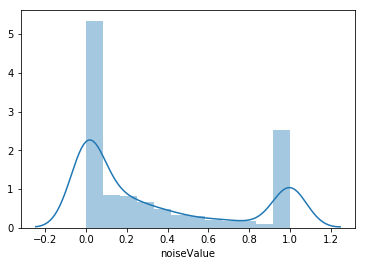

In [789]:
utils.plot_dist_graph(hosts_cog, 'noiseValue')

In [848]:
def gender_analysis(cog_table, full_ids, shared_ids, joined):
    
    #Proportion of Genders
    utils.plot_pie_graph(cog_table[cog_table['noiseLevel'] == 'low'], 'gender', "Proportion of Genders in Airbnb listings")
    
    #Proportion of Genders in Full vs Shared
    utils.plot_pie_graph(cog_table[(cog_table['noiseLevel'] == 'low') & (cog_table['name'].isin(full_ids))], 'gender', "Proportion of Genders in Full AirBnb listings")
    utils.plot_pie_graph(cog_table[(cog_table['noiseLevel'] == 'low') & (cog_table['name'].isin(shared_ids))], 'gender', "Proportion of Genders in Shared AirBnb listings")
    
    #Proportion of Genders across the years 
    joined = joined.astype(int)
    plot_yearly_distributions(cog_table, joined, 'gender', ['male', 'female'])
    
    #Proportion of Genders in Full vs Shared over the years 
    plot_yearly_distributions_room_type(cog_table, joined, 'gender', ['male', 'female'], {'full':full_ids, 'shared':shared_ids} )

In [849]:
hosts_joined = hosts_joined[hosts_joined.id.str.isnumeric()]

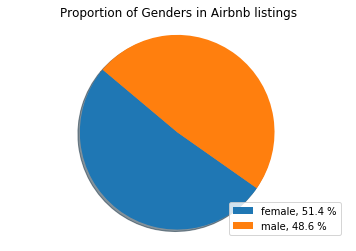

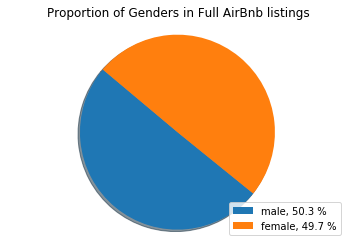

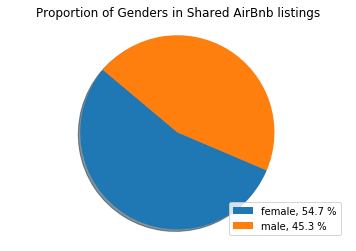

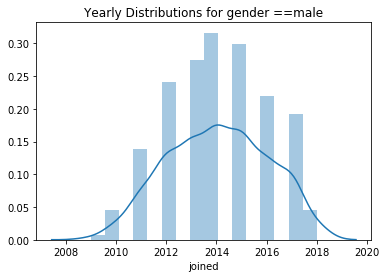

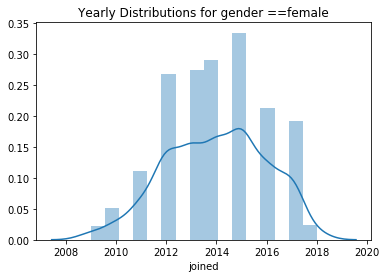

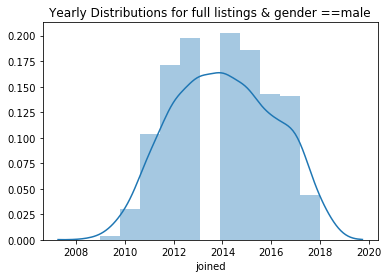

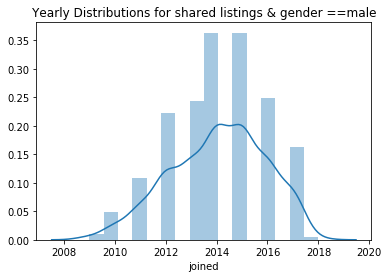

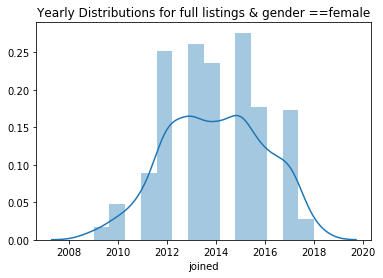

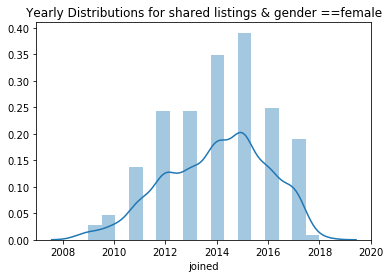

In [850]:
gender_analysis(hosts_cog, full_listings['host_id'].unique(), share_listings['host_id'].unique(), hosts_joined)

More Female Hosts than Males 
Growth in Shared Faster than Apartments
Get Male and Female next to each other

In [793]:
pd.concat([guests_cog['age'], hosts_cog['age']]).describe()

count    46764.000000
mean        34.346484
std         10.306416
min          0.000000
25%         27.000000
50%         33.000000
75%         39.000000
max         71.000000
Name: age, dtype: float64

In [815]:
def plot_yearly_distributions_room_type(res_tbl, year_tbl, crit_col, criteria, room_type_ids):
    for c in criteria:
        for k in room_type_ids.keys(): 
            utils.plot_dist_graph(year_tbl[year_tbl['id'].isin(res_tbl[(res_tbl['noiseLevel'] == 'low') & (res_tbl[crit_col] == c) & (res_tbl['name'].isin(room_type_ids[k]))]['name'].unique())], 'joined', title="Yearly Distributions for " + k + " listings & " + crit_col + " ==" + str(c) )
            
            
            

In [812]:
def plot_yearly_distributions(res_tbl, year_tbl, crit_col, criteria):
    for c in criteria:
        utils.plot_dist_graph(year_tbl[year_tbl['id'].isin(res_tbl[(res_tbl['noiseLevel'] == 'low') & (res_tbl[crit_col] == c)]['name'].unique())], 'joined', title="Yearly Distributions for " + crit_col + " ==" + str(c) )
        

In [816]:
def age_analysis(cog_table, full_ids, shared_ids, joined):
    
    #Proportion of Age
    utils.plot_pie_graph(cog_table[cog_table['noiseLevel'] == 'low'], 'ageQ', "Proportion of Age in Airbnb listings")
    
    #Proportion of Ages in Full vs Shared
    full_age = cog_table[(cog_table['noiseLevel'] == 'low') & (cog_table['name'].isin(full_ids))]
    shared_age = cog_table[(cog_table['noiseLevel'] == 'low') & (cog_table['name'].isin(shared_ids))]
    
    utils.plot_pie_graph(full_age, 'ageQ', "Proportion of Age in Full AirBnb listings")
    print("Total", len(full_age))
    utils.plot_pie_graph(shared_age, 'ageQ', "Proportion of Age in Shared AirBnb listings")
    print("Total", len(shared_age))

    #Proportion of Ages across the years 
    joined = joined.astype(int)
    plot_yearly_distributions(cog_table, joined, 'ageQ', [1, 2, 3, 4])
    
    #Proportion of Genders in Full vs Shared over the years 
    plot_yearly_distributions_room_type(cog_table, joined, 'ageQ', [1, 2, 3, 4], {'full':full_ids, 'shared':shared_ids})

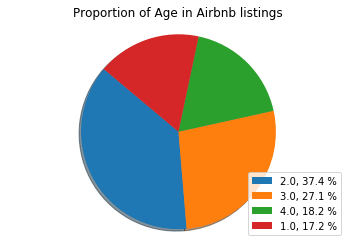

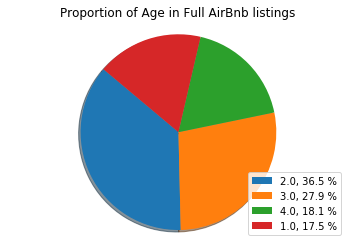

Total 1450


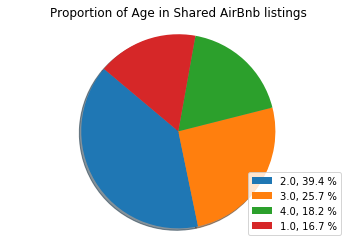

Total 724


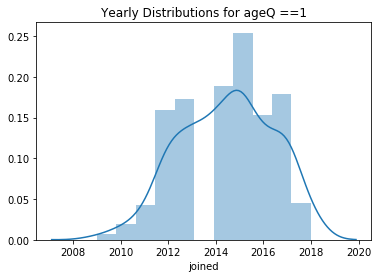

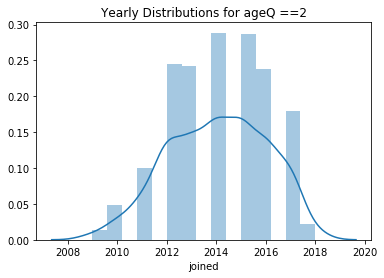

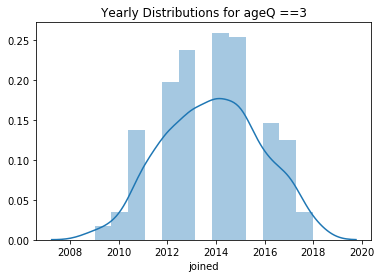

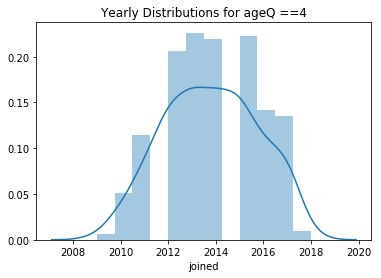

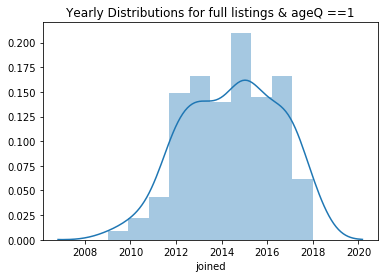

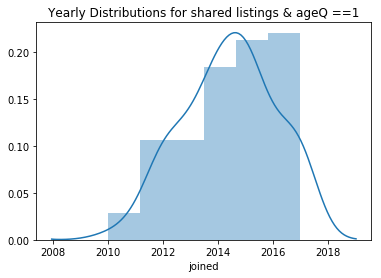

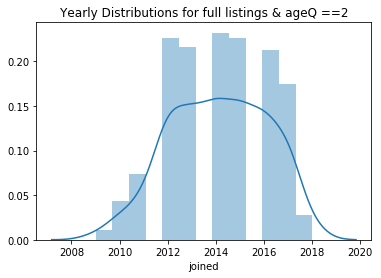

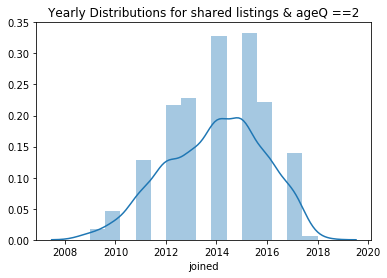

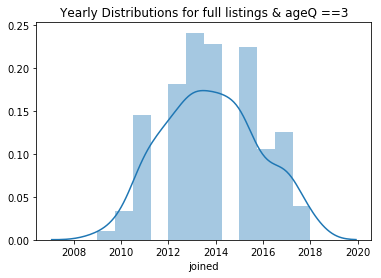

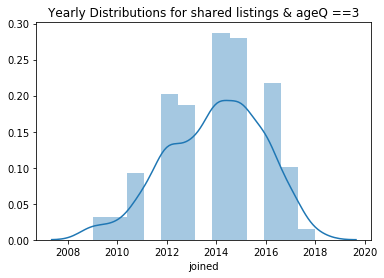

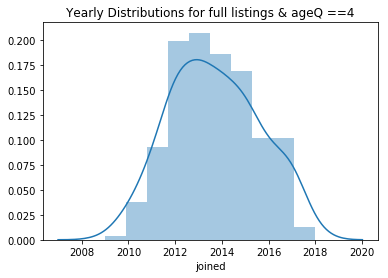

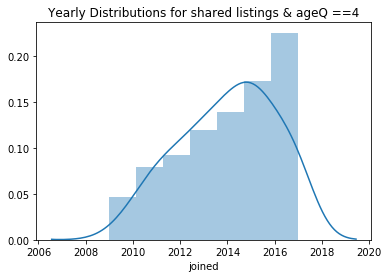

In [817]:
age_analysis(hosts_cog, full_listings['host_id'].unique(), share_listings['host_id'].unique(), hosts_joined)

## Guests

### Total

In [821]:
len(guests_cog[guests_cog['age'].isnull()])*100/len(guests_cog)

17.83466926361525

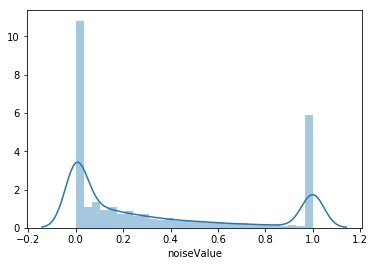

In [827]:
utils.plot_dist_graph(guests_cog, 'noiseValue')

In [836]:
full_guests = nr_reviews[nr_reviews['listing_id'].isin(full_listings['id'])]['reviewer_id'].unique()
shared_guests = nr_reviews[nr_reviews['listing_id'].isin(share_listings['id'])]['reviewer_id'].unique()

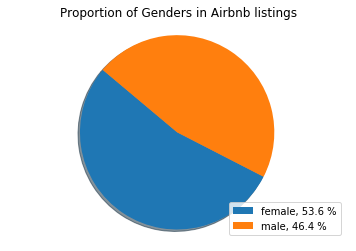

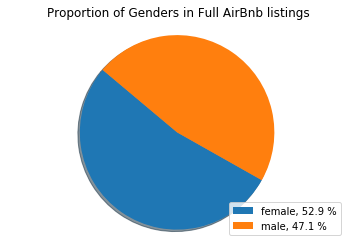

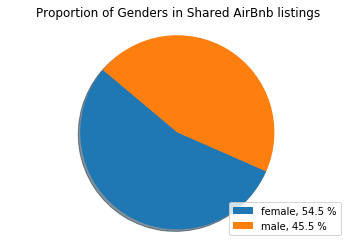

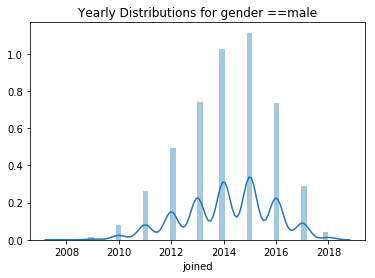

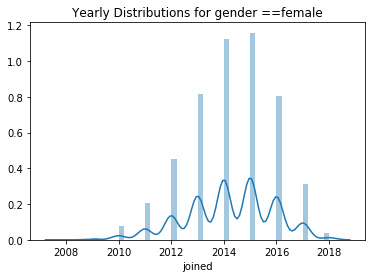

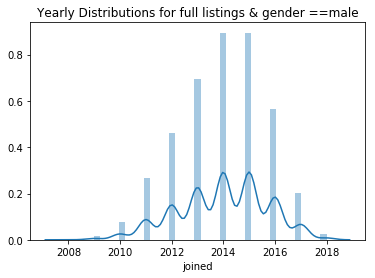

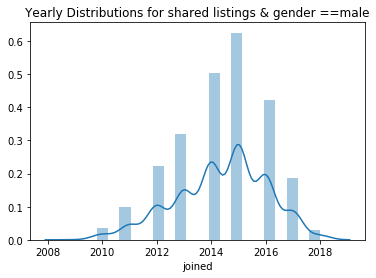

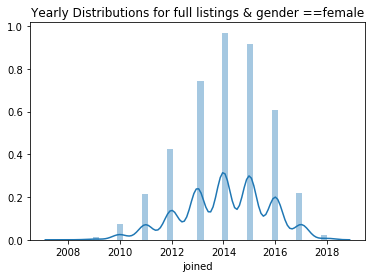

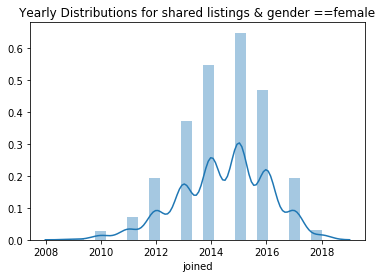

In [851]:
gender_analysis(guests_cog, full_guests, shared_guests, guests_joined)

More Female Guests than Males 
Growth in Full Faster than Apartments
Get Male and Female next to each other

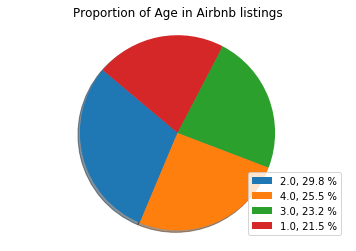

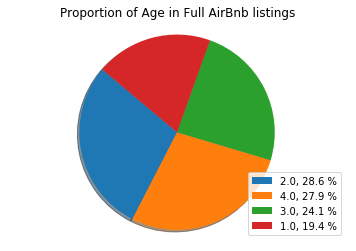

Total 21281


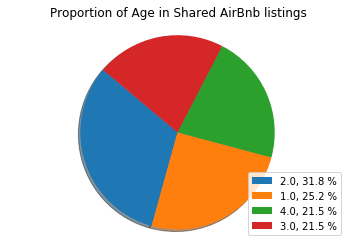

Total 12015


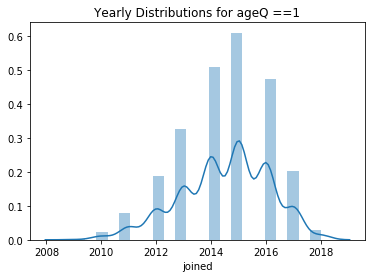

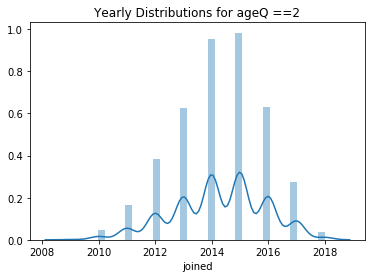

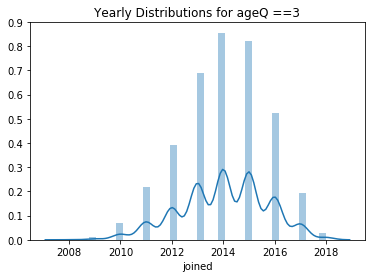

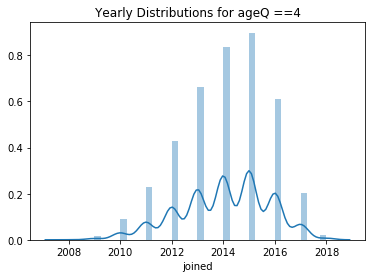

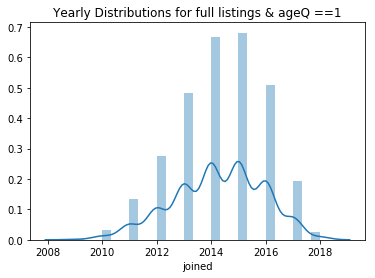

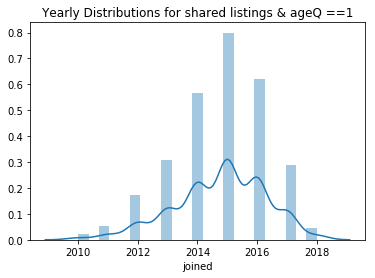

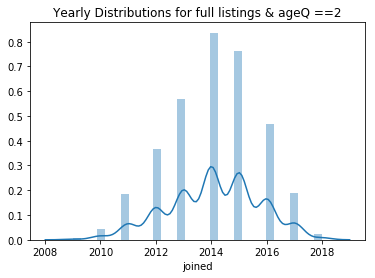

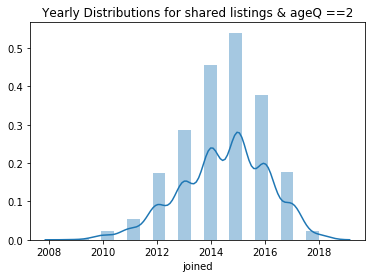

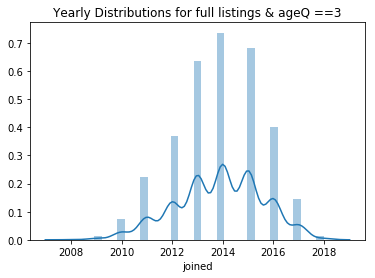

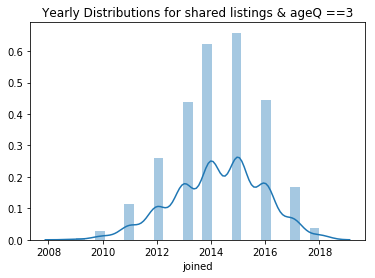

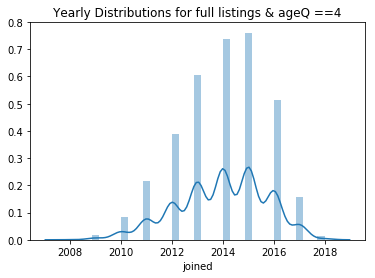

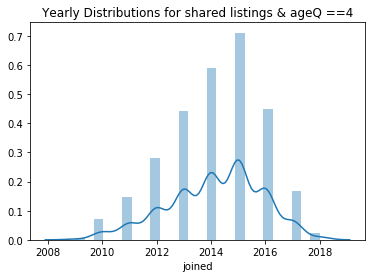

In [853]:
age_analysis(guests_cog, full_guests, shared_guests,guests_joined)

## Match ups

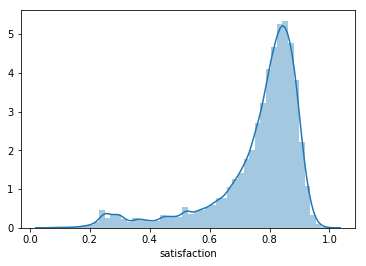

In [951]:
sns.distplot(reviews['satisfaction'])
plt.show()

In [954]:
reviews['host_gender'] = reviews.join(hosts_cog_final.set_index('name'), on='recipient_id')['gender']

In [955]:
reviews['guest_gender'] = list(reviews.join(guests_cog_final.set_index('name'), on='reviewer_id')['gender'])

In [958]:
reviews_full = reviews[reviews['listing_id'].isin(full_listings['id'].unique())]

In [959]:
reviews_shared = reviews[reviews['listing_id'].isin(share_listings['id'].unique())]

In [962]:
print("Total Full Listings:", len(reviews_full))

Total Full Listings: 11051


In [961]:
print("Total Shared Listings:", len(reviews_shared))

Total Shared Listings: 7277


## Full

Gender

Guest to Host

In [966]:
f_m_gender = reviews_full[(reviews_full['guest_gender'] == 'female') & (reviews_full['host_gender'] == 'male')]
f_f_gender = reviews_full[(reviews_full['guest_gender'] == 'female') & (reviews_full['host_gender'] == 'female')]
m_m_gender = reviews_full[(reviews_full['guest_gender'] == 'male') & (reviews_full['host_gender'] == 'male')]
m_f_gender = reviews_full[(reviews_full['guest_gender'] == 'male') & (reviews_full['host_gender'] == 'female')]
same_gender = pd.concat([f_f_gender, m_m_gender])
diff_gender = pd.concat([m_f_gender, f_m_gender])
fem_guest = pd.concat([f_f_gender, f_m_gender])
male_guest = pd.concat([m_f_gender, m_m_gender])

In [1058]:
len(diff_gender)

5283

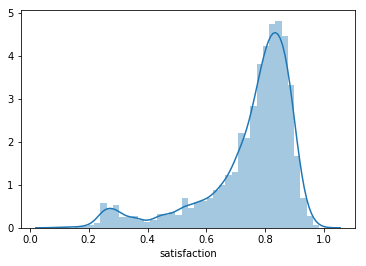

In [984]:
utils.plot_dist_graph(m_f_gender, 'satisfaction')

In [996]:
f_f_gender['satisfaction'].describe()

count    3005.000000
mean        0.765509
std         0.150043
min         0.084000
25%         0.734572
50%         0.813426
75%         0.857834
max         0.991375
Name: satisfaction, dtype: float64

males rate males harsher than women 

# Shared

In [999]:
f_m_gender_shared = reviews_shared[(reviews_shared['guest_gender'] == 'female') & (reviews_shared['host_gender'] == 'male')]
f_f_gender_shared = reviews_shared[(reviews_shared['guest_gender'] == 'female') & (reviews_shared['host_gender'] == 'female')]
m_m_gender_shared = reviews_shared[(reviews_shared['guest_gender'] == 'male') & (reviews_shared['host_gender'] == 'male')]
m_f_gender_shared = reviews_shared[(reviews_shared['guest_gender'] == 'male') & (reviews_shared['host_gender'] == 'female')]
same_gender_shared = pd.concat([f_f_gender_shared, m_m_gender_shared])
diff_gender_shared = pd.concat([m_f_gender_shared, f_m_gender_shared])
fem_guest_shared = pd.concat([f_f_gender_shared, f_m_gender_shared])
male_guest_shared = pd.concat([m_f_gender_shared, m_m_gender_shared])

In [1003]:
print("f-m:", len(f_m_gender_shared), "m-m:", len(m_m_gender_shared), "f-f:", len(f_f_gender_shared), "m-f:", len(m_f_gender_shared))

f-m: 1705 m-m: 1744 f-f: 2308 m-f: 1520


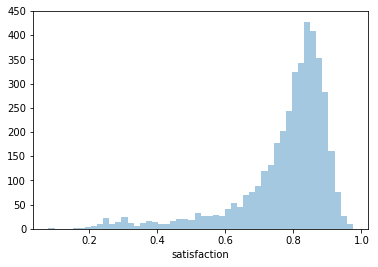

In [1009]:
utils.plot_dist_graph(same_gender_shared, 'satisfaction', kde=False)

In [1010]:
same_gender_shared['satisfaction'].describe()

count    4052.000000
mean        0.776648
std         0.137583
min         0.080500
25%         0.742108
50%         0.817071
75%         0.862649
max         0.974564
Name: satisfaction, dtype: float64

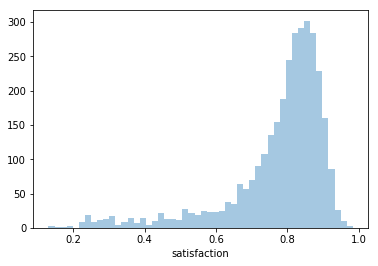

In [1008]:
utils.plot_dist_graph(diff_gender_shared, 'satisfaction', kde=False)

In [1011]:
diff_gender_shared['satisfaction'].describe()

count    3225.000000
mean        0.775607
std         0.140333
min         0.130500
25%         0.742396
50%         0.817570
75%         0.863800
max         0.983853
Name: satisfaction, dtype: float64

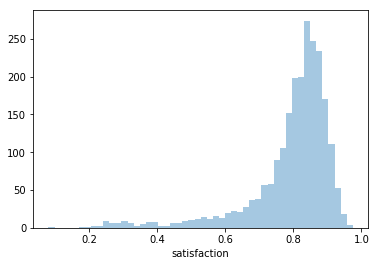

In [1012]:
utils.plot_dist_graph(f_f_gender_shared, 'satisfaction', kde=False)

In [1013]:
f_f_gender_shared['satisfaction'].describe()

count    2308.000000
mean        0.792479
std         0.126440
min         0.080500
25%         0.766123
50%         0.828376
75%         0.868354
max         0.974564
Name: satisfaction, dtype: float64

In [1437]:
m_m_gender_shared[m_m_gender_shared['satisfaction'] <0.3]

,idReview,id,date,reviewer_id,listing_id,recipient_id,comments,hostCancelled,token_len,num_of_sents,google_langs,google_langs_conf,langdetect_langs,langdetect_langs_conf,other_langs,translated,satisfaction,host_gender,guest_gender
25251,52298,105153395,2016-09-30,443978,218358,1129218,Orlando is a very courteous host and his place...,N,35,3,en,1.0,en,0.999995,['sv'],Orlando is a very courteous host and his place...,0.28300,male,male
60642,123343,189717320,2017-09-02,69950170,751818,3937164,The location of the accommodation was good(The...,N,60,5,en,1.0,en,0.999997,0,NaN,0.22600,male,male
68769,138204,40231377,2015-07-29,3643291,846829,395609,JB was not in the country when we went but get...,N,60,3,en,1.0,en,0.999993,0,NaN,0.28200,male,male
73313,147736,30317765,2015-04-20,4136048,916514,4920078,"Daniel is a great host, friendly. We have not ...",N,77,9,en,1.0,en,0.999997,0,NaN,0.21750,male,male
73495,148113,21138629,2014-10-12,6690701,919830,1895793,Eduardo was a genial host and his apartment wa...,N,72,3,en,1.0,en,0.999997,0,NaN,0.19750,male,male
102371,208095,21706448,2014-10-22,11763542,1785187,8222814,"Close to subway, many bus lines. It takes arou...",N,67,6,en,1.0,en,0.999997,0,NaN,0.24100,male,male
105029,214089,181412782,2017-08-12,142688453,1881846,586409,"My first Airbnb experience, everything I expec...",N,9,1,en,1.0,en,0.999995,0,NaN,0.24900,male,male
129715,265847,29003561,2015-04-02,7139073,2968070,14380456,Freezing New York was made bearable by the war...,N,112,6,en,1.0,en,0.999996,0,NaN,0.27900,male,male
129816,265948,122166331,2016-12-21,57463491,2968070,14380456,Strongly recommended. 5 minutes to time square...,N,19,3,en,1.0,en,0.999997,0,NaN,0.28600,male,male
136714,281520,127187823,2017-01-16,70079001,3404873,17171419,Extremely dissappointing. If a mattress is go...,N,46,5,en,1.0,en,0.999995,0,NaN,0.22800,male,male


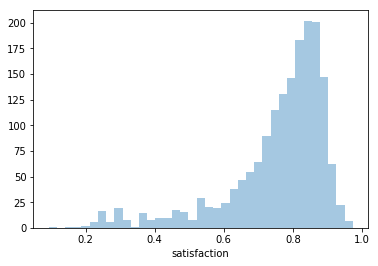

In [1014]:
utils.plot_dist_graph(m_m_gender_shared, 'satisfaction', kde=False)

In [1015]:
m_m_gender_shared['satisfaction'].describe()

count    1744.000000
mean        0.755697
std         0.148535
min         0.093000
25%         0.711020
50%         0.801052
75%         0.855472
max         0.973611
Name: satisfaction, dtype: float64

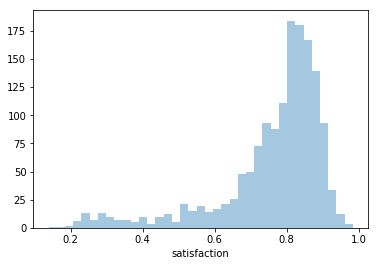

In [1016]:
utils.plot_dist_graph(m_f_gender_shared, 'satisfaction', kde=False)

In [1017]:
m_f_gender_shared['satisfaction'].describe()

count    1520.000000
mean        0.760807
std         0.149324
min         0.138500
25%         0.721365
50%         0.807642
75%         0.855400
max         0.983853
Name: satisfaction, dtype: float64

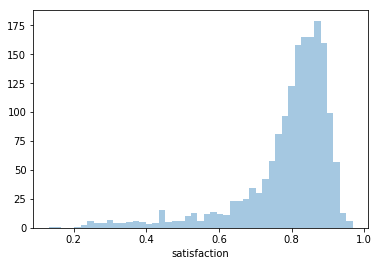

In [1018]:
utils.plot_dist_graph(f_m_gender_shared, 'satisfaction', kde=False)

In [1019]:
f_m_gender_shared['satisfaction'].describe()

count    1705.000000
mean        0.788801
std         0.130438
min         0.130500
25%         0.762457
50%         0.825166
75%         0.869723
max         0.968723
Name: satisfaction, dtype: float64

# Gender 

In [1031]:
reviews['host_ageQ'] = reviews.join(hosts_cog_final.set_index('name'), on='recipient_id')['ageQ']

In [1032]:
reviews['guest_ageQ'] = list(reviews.join(guests_cog_final.set_index('name'), on='reviewer_id')['ageQ'])

In [1033]:
reviews['ageQ_diff'] = reviews['host_ageQ']  - reviews['guest_ageQ']

In [1034]:
reviews['ageQ_diff_abs'] = np.abs(reviews['ageQ_diff'])

In [1035]:
reviews['host_age'] = reviews.join(hosts_cog_final.set_index('name'), on='recipient_id')['age']

In [1036]:
reviews['guest_age'] = list(reviews.join(guests_cog_final.set_index('name'), on='reviewer_id')['age'])

In [1037]:
reviews['age_diff'] = reviews['host_age']  - reviews['guest_age']

In [1038]:
reviews['age_diff_abs'] = np.abs(reviews['age_diff'])

In [1039]:
reviews_full = reviews[reviews['listing_id'].isin(full_listings['id'].unique())]

reviews_shared = reviews[reviews['listing_id'].isin(share_listings['id'].unique())]

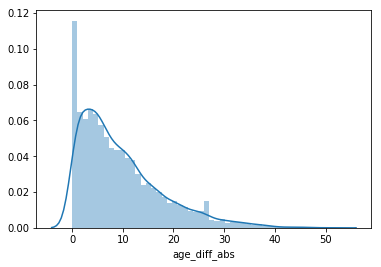

In [1042]:
utils.plot_dist_graph(reviews_full, 'age_diff_abs')

In [1049]:
reviews_full['age_diff_abs'].describe()

count    11051.000000
mean         9.641299
std          8.150319
min          0.000000
25%          3.000000
50%          8.000000
75%         14.000000
max         52.000000
Name: age_diff_abs, dtype: float64

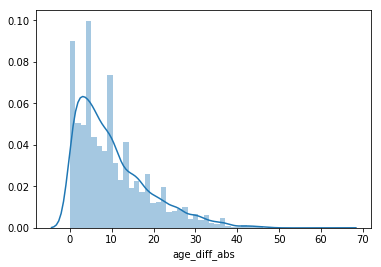

In [1043]:
utils.plot_dist_graph(reviews_shared, 'age_diff_abs')

In [1050]:
reviews_shared['age_diff_abs'].describe()

count    7277.000000
mean       10.241033
std         8.702897
min         0.000000
25%         4.000000
50%         8.000000
75%        15.000000
max        64.000000
Name: age_diff_abs, dtype: float64

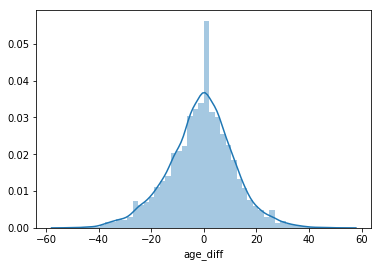

In [1045]:
utils.plot_dist_graph(reviews_full, 'age_diff')

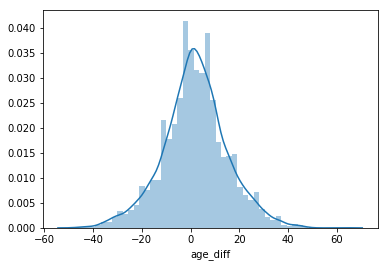

In [1044]:
utils.plot_dist_graph(reviews_shared, 'age_diff')

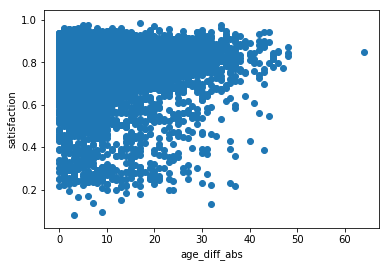

In [1047]:
plt.scatter(reviews_shared['age_diff_abs'], reviews_shared['satisfaction'])
plt.xlabel('age_diff_abs')
plt.ylabel('satisfaction')
plt.show()

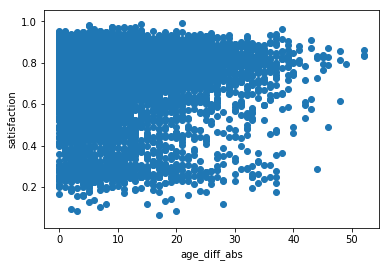

In [1048]:
plt.scatter(reviews_full['age_diff_abs'], reviews_full['satisfaction'])
plt.xlabel('age_diff_abs')
plt.ylabel('satisfaction')
plt.show()

In [ ]:
Host - older than guest , guest is older than host, same , 1 quad diff, 2 quad diff, 3 quad diff

# Extra

In [721]:
hosts_joined = pd.DataFrame()

In [722]:
hosts_joined['id'], hosts_joined['joined'] = nr_hosts['id'] , nr_hosts.since.str.split('-',expand=True)[0]

In [830]:
guests_joined = pd.DataFrame()

In [841]:
guests_joined['id'], guests_joined['joined'] = nr_guests['id'] , nr_guests['membershipYear']

The highest review is it from Most similar or not , Lowest review 

In [431]:
duplicate_guests = set(old_guests_cognitive['name'].unique()).intersection(set(new_guests_cognitive['name'].unique()))

In [434]:
old_guests_cognitive = old_guests_cognitive[~old_guests_cognitive['name'].isin(duplicate_guests)]

In [254]:
def check_if_pic_exists(img_dir, no_img_dir, ids):
    tbl = pd.DataFrame({'id':list(ids)})
    exists = []
    for i in ids:
        pwd = os.path.join(img_dir, str(i) +'.jpg')
        no_pwd = os.path.join(no_img_dir, str(i) +'.jpg')
        if os.path.isfile(no_pwd):
            exists.append(0)
        elif os.path.isfile(pwd):
            exists.append(1)
        else:
            exists.append(-1)
    tbl['exists'] = exists
    return tbl

In [367]:
for t, data in zip(range(15),np.array_split(guest_redo['id'].unique(), 15)):
    pd.DataFrame({'id':data}).to_csv('guests/g_in_' + str(t) +'.csv')

In [381]:
no_pip_guest = set(new_indicio[new_indicio['bounding_box'] == '(None, None, None, None)']['id'])

In [383]:
pip_guest  = new_indicio.groupby("id").count().rename(columns={'bounding_box': 'num_of_people'})

In [387]:
zero_guests = pd.DataFrame({'id':list(no_pip_guest), 'num_of_people':np.zeros(len(no_pip_guest))})

In [1346]:
import glob

In [1352]:
crop_h = set([int(i.split('/')[-1].split('.')[0]) for i in glob.glob("hosts-cropped/"+ '*.jpg')[::-1]])

In [1353]:
needed_hosts = set( h_one_ids) - set(hosts_cog[~hosts_cog['noiseLevel'].isnull()]['name'])

In [1354]:
len(needed_hosts)

379

In [1355]:
n_hosts = needed_hosts - crop_h

In [1356]:
len(n_hosts)

1

In [1357]:
crop_g = set([int(i.split('/')[-1].split('.')[0]) for i in glob.glob("guests-cropped/"+ '*.jpg')[::-1]])

In [1358]:
len(crop_g)

9827

In [1359]:
needed_guests =  set( g_one_ids) - set(guests_cog[~guests_cog['noiseLevel'].isnull()]['name'])

In [1360]:
len(needed_guests)

3861

In [1361]:
n_guests = needed_guests - crop_g

In [1362]:
len(n_guests)

0